### Import Library & Data

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

In [3]:
df = pd.read_csv('Data/PMobX_NPS_Analysis.csv')
df = df.dropna(axis=1, how='all')
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment App Related               Key Theme  \
0     Negative         Yes  Features and Promotion   
1     Negative         Yes             Reliability   
2     Negative         Yes     UI/UX and Usability   
3     Negative         Yes     UI/UX and Usability   
4     Negative         Yes          Fees and Rates   
...        ...         ...                     ...   
4012  Negative          No                Services   
4013  Negative         Yes                Services   
4014   Neutral          No                 General   
4015  Negative         Yes     UI/UX and Usability   
4016  Negative          No                Services   

                       Specific Themes  
0                     Missing Features  
1                  Failed Transactions  
2                        Complex UI/UX  
3     Application is not user-friendly  
4              Limitations on transfer  
...                                ...  
4012                  Language barrier  
4013                  Transfer failure  
4014                  Neutral feedback  
4015          App accessibility issues  
4016                Lack of facilities  

[4017 rows x 6 columns]

### 1. Cleaning Data

In [4]:
df = df[['Date', 'Feedback', 'Sentiment','Key Theme']]
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  Kenapa transfer dibawah 1000 ditiadakan. Padah...   
...               ...                                                ...   
4012   8/27/2024 3:50  needs easier access to English speaking teleph...   
4013   8/27/2024 5:42                      masa gak bisa transfer. error   
4014   8/27/2024 6:00                                                 ok   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4012  Negative                Services  
4013  Negative                Services  
4014   Neutral                 General  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[4017 rows x 4 columns]

In [5]:
df.shape

(4017, 4)

In [6]:
# remove duplicates
df = df.drop_duplicates(subset='Feedback')

# remove empty rows
df = df.dropna()

df.shape

(3006, 4)

In [7]:
# Cleaning data
def clean_Feedback_data(text):
    # Remove mentions (e.g., @username)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags (e.g., #keyword)
    text = re.sub(r'#\w+', '', text)
    # Remove retweet markers (e.g., RT at the beginning of retweeted messages)
    text = re.sub(r'RT[\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    # Remove numbers (e.g., transaction IDs or dates)
    text = re.sub(r'\d+', '', text)
    # Remove non-alphanumeric characters (keeping only letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    # Remove "-nya" suffix from words (both combined and separated forms)
    text = re.sub(r'\b(\w+?)\s?nya\b', r'\1', text)
    # Remove extra characters (e.g., "ssseeeppiiii" -> "sepi")
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['Feedback'] = df['Feedback'].apply(clean_Feedback_data)

In [8]:
# lower case
df['Feedback'] = df['Feedback'].str.lower()

In [9]:
df.head(10)

Date                                           Feedback  \
0  7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1  7/14/2024 19:46                                transfer gagal mulu   
2  7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3  7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4   7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
5   7/15/2024 7:53  antrian lama bgt saat di bank harap dipercepat...   
6   7/15/2024 9:16                                         w paylorld   
7  7/15/2024 10:16                                              delay   
8  7/15/2024 13:40  i have had a lot of trouble logging into perma...   
9  7/15/2024 15:45  ga tau kenapa sekarang aplikasi lemot banget p...   

  Sentiment               Key Theme  
0  Negative  Features and Promotion  
1  Negative             Reliability  
2  Negative     UI/UX and Usability  
3  Negative     UI/UX and Usability  
4  Negative          Fees and Rates  
5  Negative                Services  
6   Neutral  Features and Promotion  
7  Negative          Ease and Speed  
8  Negative             Reliability  
9  Negative          Ease and Speed

### 2. Preprocessing

In [10]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='en', target='id')

df['Feedback'] = df['Feedback'].apply(lambda x: translator.translate(x))
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4011   8/27/2024 2:49                                      semuanya baik   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   
4016   8/27/2024 6:44                                   fasilitas kurang   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4011  Positive                 General  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  
4016  Negative                Services  

[3006 rows x 4 columns]

In [12]:
# import os
# import pandas as pd

# # Pastikan folder 'Data' ada
# if not os.path.exists('Data'):
#     os.makedirs('Data')

# # Simpan DataFrame ke file Excel baru di folder 'Data'
# df.to_excel('Data/data_bersih_baru.xlsx', index=False)


In [11]:
# Define a function to filter rows
def filter_tokens_by_length(dataframe, column_name, min_words, max_words):
    # Count the number of words in each entry of the specified column
    # .astype(str) ensures the data is treated as a string, even if it has other types
    words_count = dataframe[column_name].astype(str).apply(lambda x: len(x.split()))
    # Create a mask (Boolean series) that checks if the word count is within the specified range
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = dataframe[mask]
    return filtered_df

# Define minimum and maximum word count for filtering
min_words = 3
max_words = 50
df = filter_tokens_by_length(df, 'Feedback', min_words, max_words)
df

Date                                           Feedback  \
0     7/14/2024 19:27              tidak ada fitur qris utk kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau ada perubahan biometrik harus registrasi...   
3     7/14/2024 20:31         bentuk aplikasi kurang menarik dan praktis   
4      7/15/2024 5:41  kenapa transfer dibawah ditiadakan padahal itu...   
...               ...                                                ...   
4009   8/27/2024 1:25  apk pertama sedikit berat untuk loginmohon unt...   
4010   8/27/2024 2:40  pembayaran melalui kode qr sering gagal padaha...   
4012   8/27/2024 3:50  membutuhkan akses yang lebih mudah ke agen tel...   
4013   8/27/2024 5:42                       masa gak bisa transfer error   
4015   8/27/2024 6:41                   aplikasi terkadang susah di buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [12]:
df.shape

(2439, 4)

In [14]:
import ast

# Load the normalization dictionary from the file
with open("Data/Combined_data.txt", "r") as kamus_file:
    norm = ast.literal_eval(kamus_file.read())

# Define the normalization function with selective replacement for 'qr'
def normalize(str_text):
    # Handle 'qr' specifically to avoid changing existing 'qris'
    words = str_text.split()  # Split text into words to process individually
    normalized_words = []
    
    for word in words:
        # Replace 'qr' with 'qris' only if it matches exactly 'qr'
        if word == "qr":
            normalized_words.append("qris")
        else:
            # Check if word is in dictionary, else use the word as is
            normalized_words.append(norm.get(word, word))
    
    return " ".join(normalized_words)

# Apply the normalization to the 'Feedback' column
df['Feedback'] = df['Feedback'].apply(normalize)


C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\1343888445.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Feedback'] = df['Feedback'].apply(normalize)


In [15]:
# Import the necessary libraries
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# Define additional stop words (if any)
more_stop_words = []

# Initialize stop words and extend with additional stop words if needed
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

# Create a custom dictionary with stop words
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

# Define a function to remove stop words
def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

# Apply the stopword function to the 'Feedback' column using .loc to avoid the warning
df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)

# Display the DataFrame
df


C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\3705476412.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Feedback'] = df['Feedback'].apply(stopword)


Date                                           Feedback  \
0     7/14/2024 19:27                        ada fitur qris kartu kredit   
1     7/14/2024 19:46                                transfer gagal mulu   
2     7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mob...   
3     7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4      7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
...               ...                                                ...   
4009   8/27/2024 1:25  aplikasi pertama sedikit berat loginmohon diup...   
4010   8/27/2024 2:40  pembayaran melalui kode qris sering gagal pada...   
4012   8/27/2024 3:50  membutuhkan akses lebih mudah agen telepon ber...   
4013   8/27/2024 5:42                           masa bisa transfer error   
4015   8/27/2024 6:41                      aplikasi terkadang susah buka   

     Sentiment               Key Theme  
0     Negative  Features and Promotion  
1     Negative             Reliability  
2     Negative     UI/UX and Usability  
3     Negative     UI/UX and Usability  
4     Negative          Fees and Rates  
...        ...                     ...  
4009  Negative     UI/UX and Usability  
4010  Negative     UI/UX and Usability  
4012  Negative                Services  
4013  Negative                Services  
4015  Negative     UI/UX and Usability  

[2439 rows x 4 columns]

In [16]:
#Tokenization
tokenized = df['Feedback'].apply(lambda x: x.split())
tokenized


0                       [ada, fitur, qris, kartu, kredit]
1                                 [transfer, gagal, mulu]
2       [kalau, perubahan, biometrik, registrasi, ulan...
3            [bentuk, aplikasi, kurang, menarik, praktis]
4       [transfer, dibawah, hapus, padahal, keliru, sa...
                              ...                        
4009    [aplikasi, pertama, sedikit, berat, loginmohon...
4010    [pembayaran, melalui, kode, qris, sering, gaga...
4012    [membutuhkan, akses, lebih, mudah, agen, telep...
4013                        [masa, bisa, transfer, error]
4015                   [aplikasi, terkadang, susah, buka]
Name: Feedback, Length: 2439, dtype: object

In [17]:
#Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean

tokenized = tokenized.apply(stemming)

ada fitur qris kartu kredit
transfer gagal mulu
kalau ubah biometrik registrasi ulang mobile banking awal bener bener repot aplikasi bank jika ubah biometrik cukup aktif ulang sidik jari registrasi ulang mobile banking
bentuk aplikasi kurang tarik praktis
transfer bawah hapus padahal keliru satu unggul permata banding bank
antri lama banget di bank harap cepat layan
w kuasa gaji
alami banyak kendala login mobile perban permata sistem muncul pesan kata permata x sedang alami kendala teknis kami coba nanti sangat sebal saya bayar qris depan sewa
ga tau sekarang aplikasi lambat banget padahal jaring bagus stabil mohon baik
layan bagus nyaman tahan
sering error kalau qris bisa langsung nyantol sering konek kalau bca selalu oke
pernah d acc pinjam kta padahal gaji lewat permata bayar kta lancar malah habis bayar sampe sekarang tahun pernah acc pinjam
data invest bond tidak akurat data detail
login email transaksi sangat mengangu
riwayat transaksi bagus dulu periode pilih default jadi hemat 

### 3. Labeling

In [18]:
df.head(10)

Date                                           Feedback  \
0   7/14/2024 19:27                        ada fitur qris kartu kredit   
1   7/14/2024 19:46                                transfer gagal mulu   
2   7/14/2024 19:59  kalau perubahan biometrik registrasi ulang mob...   
3   7/14/2024 20:31             bentuk aplikasi kurang menarik praktis   
4    7/15/2024 5:41  transfer dibawah hapus padahal keliru satu keu...   
5    7/15/2024 7:53  antrian lama banget di bank harap dipercepat p...   
6    7/15/2024 9:16                                    w penguasa gaji   
8   7/15/2024 13:40  mengalami banyak kendala login mobile perbanka...   
9   7/15/2024 15:45  ga tau sekarang aplikasi lambat banget padahal...   
10  7/15/2024 16:11               pelayanan bagus nyaman dipertahankan   

   Sentiment               Key Theme  
0   Negative  Features and Promotion  
1   Negative             Reliability  
2   Negative     UI/UX and Usability  
3   Negative     UI/UX and Usability  
4   Negative          Fees and Rates  
5   Negative                Services  
6    Neutral  Features and Promotion  
8   Negative             Reliability  
9   Negative          Ease and Speed  
10  Positive                Services

In [19]:
# show stemmed dataframe
# Convert the 'Date' column to datetime format and keep only the date
df['Date'] = pd.to_datetime(df['Date']).dt.date
df_stem = pd.DataFrame({'Date': df['Date'],'Feedback': tokenized, 'Sentiment': df['Sentiment'], 'Key Theme': df['Key Theme']})
df_stem

C:\Users\Andrew\AppData\Local\Temp\ipykernel_6036\4240001376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
4009  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
4010  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
4012  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
4013  2024-08-27                           masa bisa transfer error  Negative   
4015  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
4009     UI/UX and Usability  
4010     UI/UX and Usability  
4012                Services  
4013                Services  
4015     UI/UX and Usability  

[2439 rows x 4 columns]

In [20]:
import os
import pandas as pd

# Pastikan folder 'Data' ada
if not os.path.exists('Data'):
    os.makedirs('Data')

# Simpan DataFrame ke file CSV di folder 'Data'
df_stem.to_csv('Data/data_preprocessing.csv', index=False)


### Data Preprocessed

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

In [3]:
import pandas as pd

# Load the CSV file back into a DataFrame
df_stem = pd.read_csv('Data/data_preprocessing.csv')

# Display the DataFrame to verify
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [4]:
# show count all positive, negative, neutral
df_countSent = df_stem['Sentiment'].value_counts()
df_countSent

Negative    1897
Positive     404
Neutral      138
Name: Sentiment, dtype: int64

In [5]:
# show count all Categories
df_countKey = df_stem['Key Theme'].value_counts()
df_countKey

Services                  591
Ease and Speed            405
Features and Promotion    399
UI/UX and Usability       312
Reliability               290
General                   235
Fees and Rates            207
Name: Key Theme, dtype: int64

### 4. Visualization

In [6]:
# Data positive, negative, neutral
df_positive = df_stem[df_stem['Sentiment'] == 'Positive']
df_negative = df_stem[df_stem['Sentiment'] == 'Negative']
df_neutral = df_stem[df_stem['Sentiment'] == 'Neutral']

In [7]:
# Data Categories
df_services = df_stem[df_stem['Key Theme'] == 'Services']
df_reliability = df_stem[df_stem['Key Theme'] == 'Reliability']
df_features = df_stem[df_stem['Key Theme'] == 'Features and Promotion']
df_speed = df_stem[df_stem['Key Theme'] == 'Ease and Speed']
df_general = df_stem[df_stem['Key Theme'] == 'General']
df_uiux = df_stem[df_stem['Key Theme'] == 'UI/UX and Usability']
df_fees = df_stem[df_stem['Key Theme'] == 'Fees and Rates']

In [8]:
# WordCloud for each key themes and sentiment
from wordcloud import WordCloud

def generate_wordcloud (df, sentiment):
    text = " ".join(df['Feedback'].astype(str))  # Combine all feedback text
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Sentiment")
    plt.show()

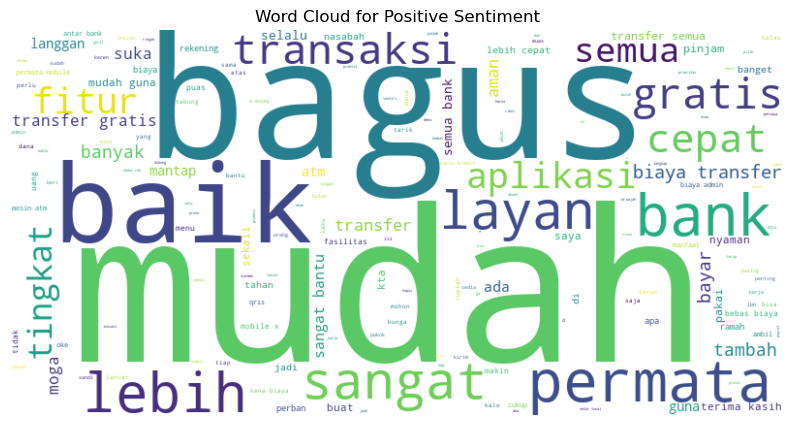

In [9]:
# Generate word clouds for positive
generate_wordcloud(df_positive, "Positive")

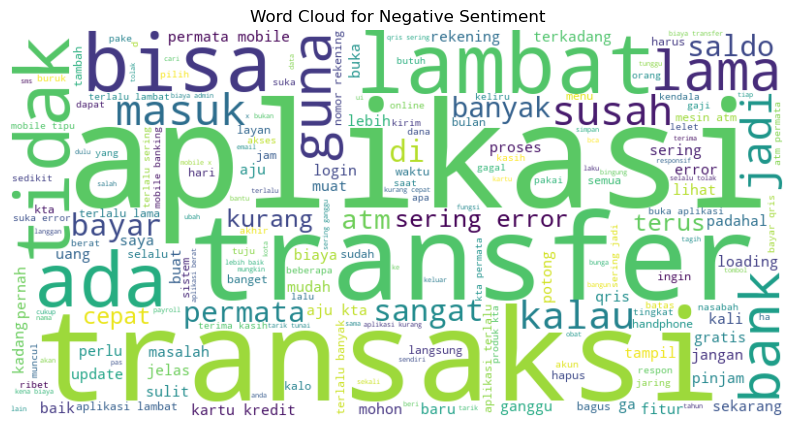

In [10]:
# Generate word clouds for negative
generate_wordcloud(df_negative, "Negative")

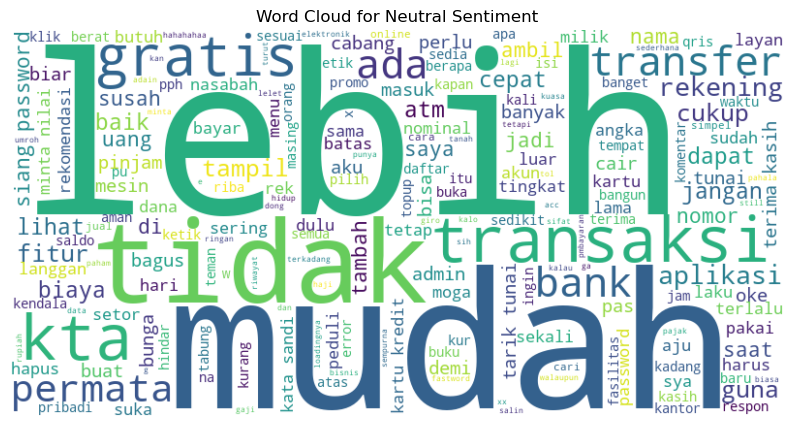

In [11]:
# Generate word clouds for neutral
generate_wordcloud(df_neutral, "Neutral")

In [12]:
def generate_wordclouds_by_theme_and_sentiment(df):
    key_themes = df['Key Theme'].unique()  # Get unique key themes
    sentiments = df['Sentiment'].unique()  # Get unique sentiments
    
    for theme in key_themes:
        for sentiment in sentiments:
            # Filter data for the current theme and sentiment
            filtered_data = df[(df['Key Theme'] == theme) & (df['Sentiment'] == sentiment)]
            
            if not filtered_data.empty:  # Proceed only if there is data for the combination
                text = " ".join(filtered_data['Feedback'].astype(str))  # Combine feedback text
                
                # Generate the WordCloud
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
                
                # Plot the WordCloud
                plt.figure(figsize=(10, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Word Cloud for {theme} ({sentiment} Sentiment)")
                plt.show()

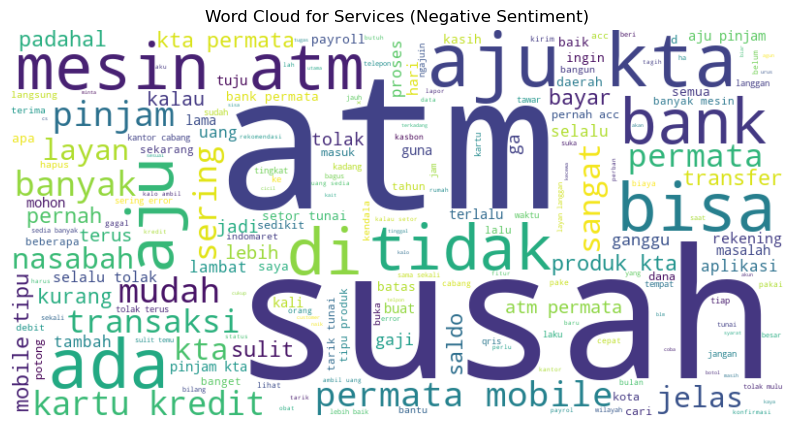

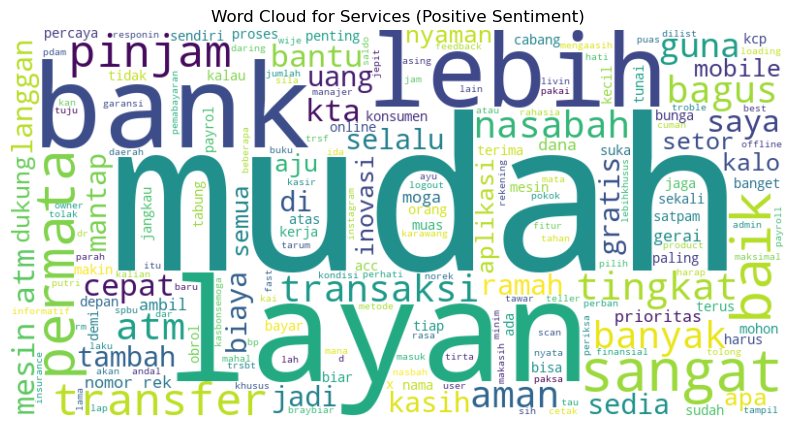

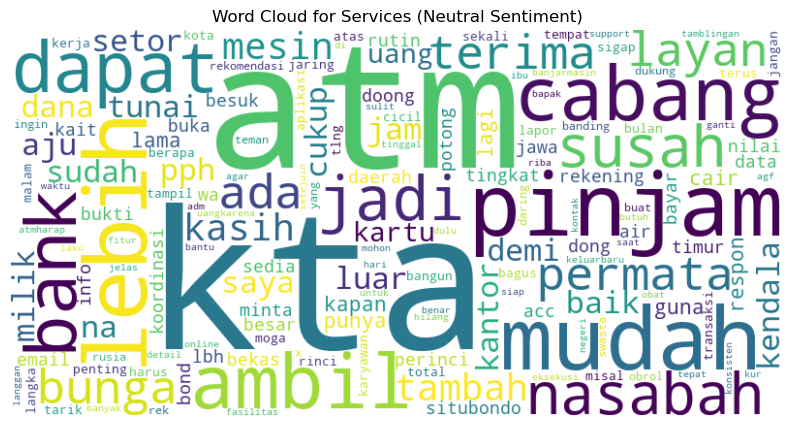

In [13]:
# Generate word clouds for Services and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_services)



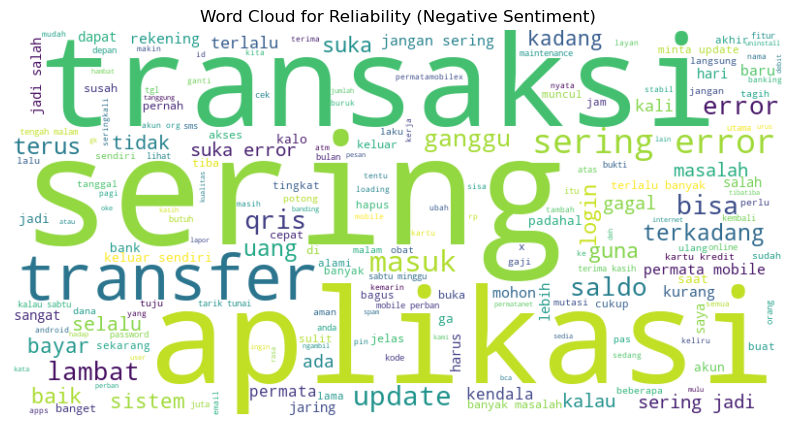

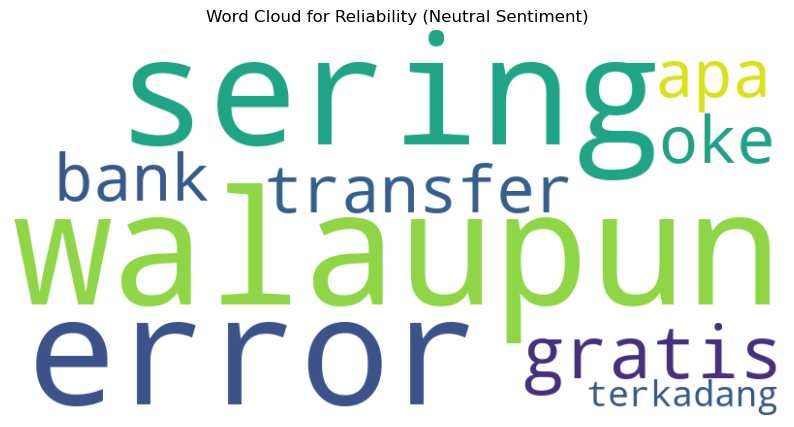

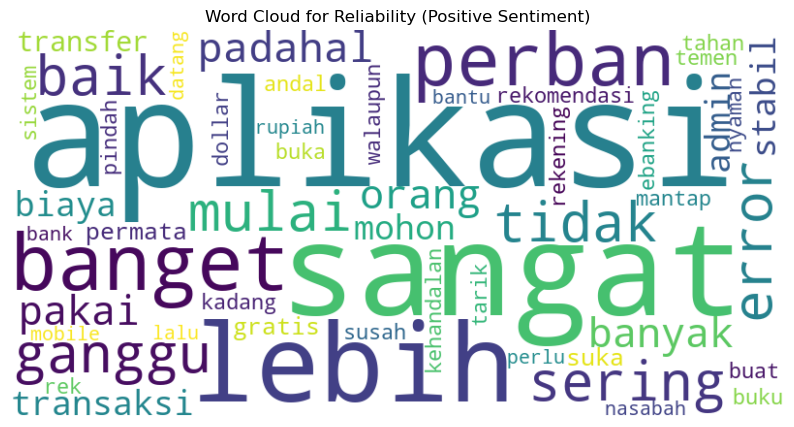

In [14]:
# Generate word clouds for Reliability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_reliability)

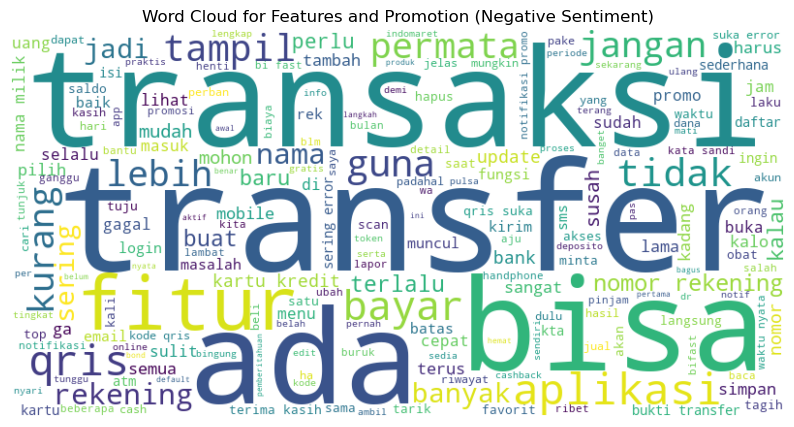

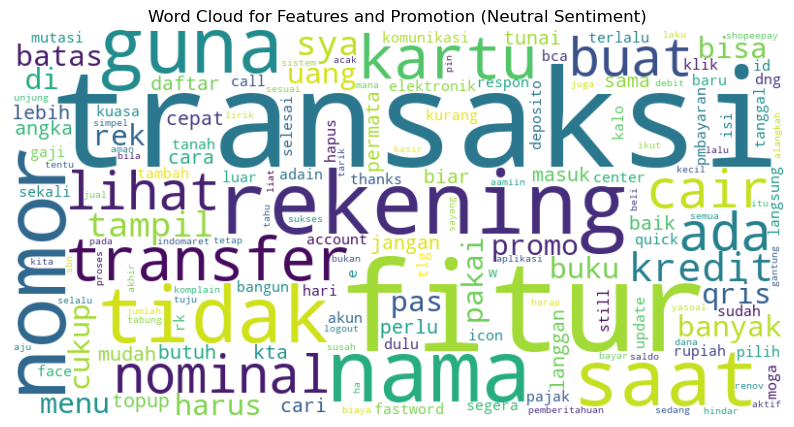

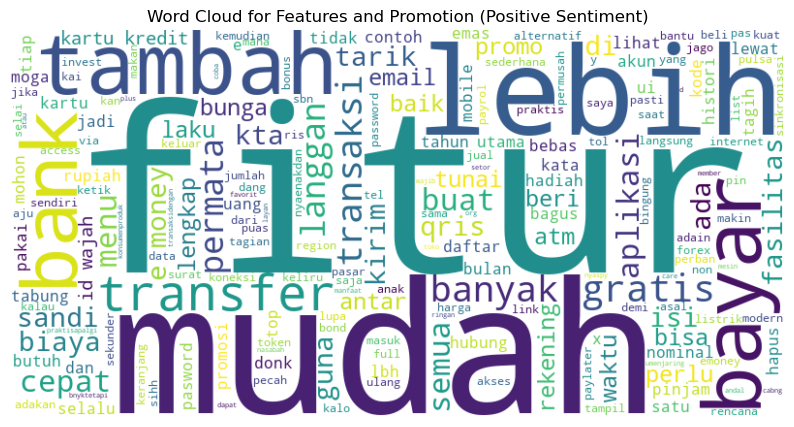

In [15]:
# Generate word clouds for Features and Promotion and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_features)

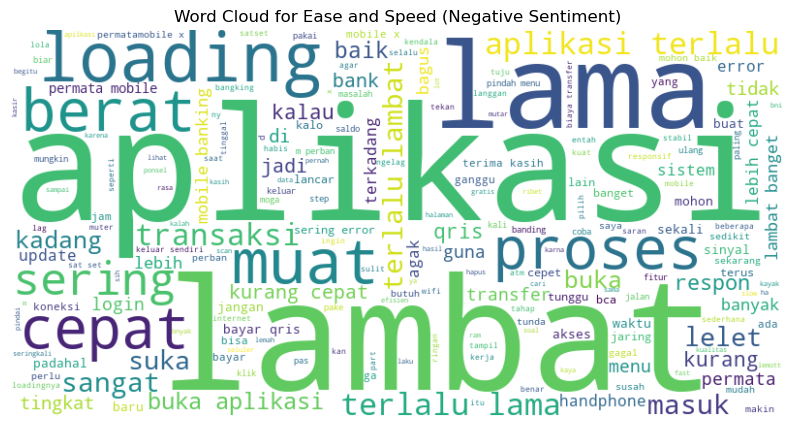

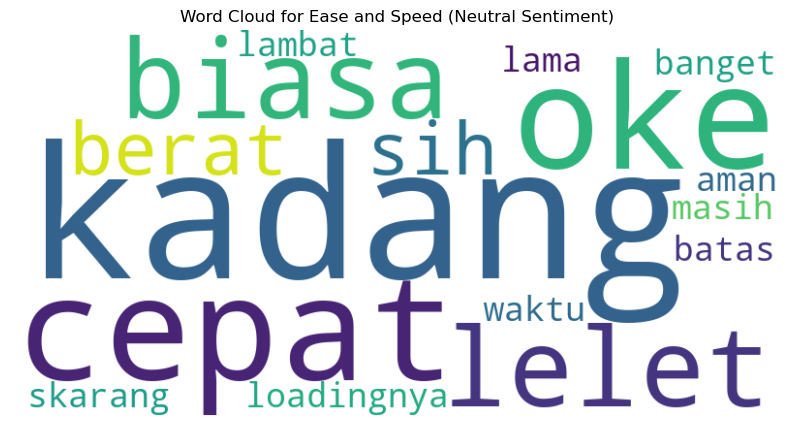

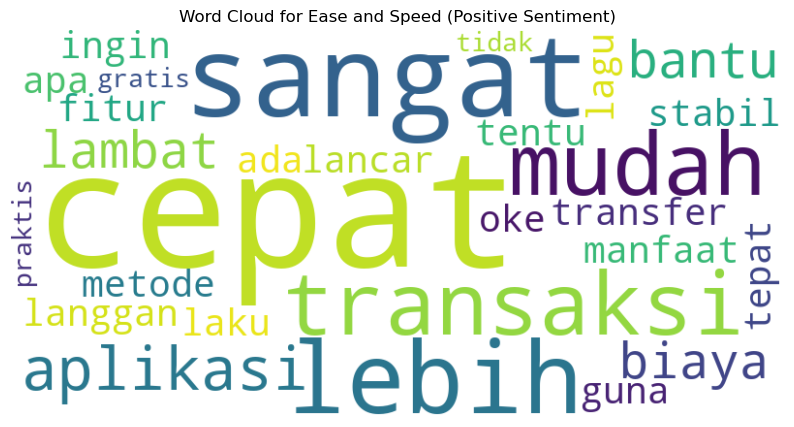

In [16]:
# Generate word clouds for Speed and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_speed)

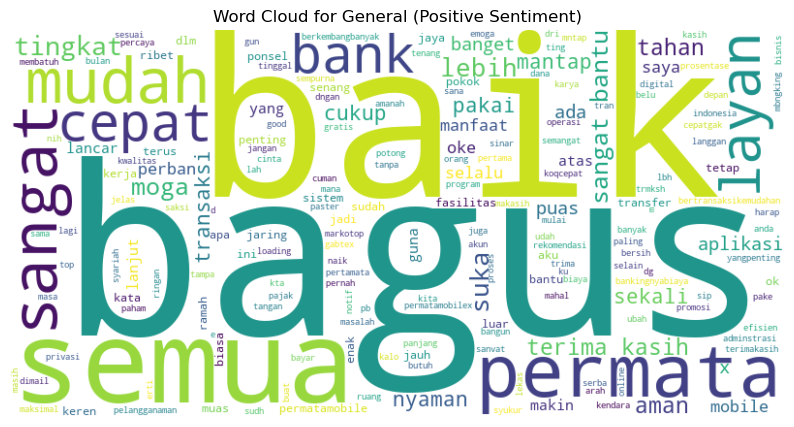

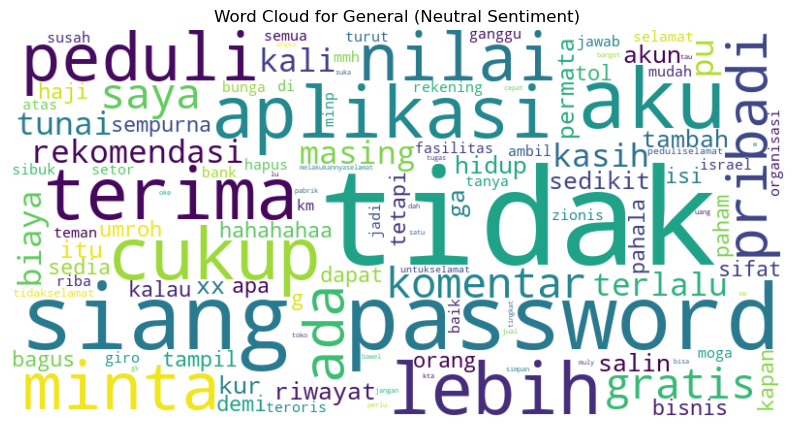

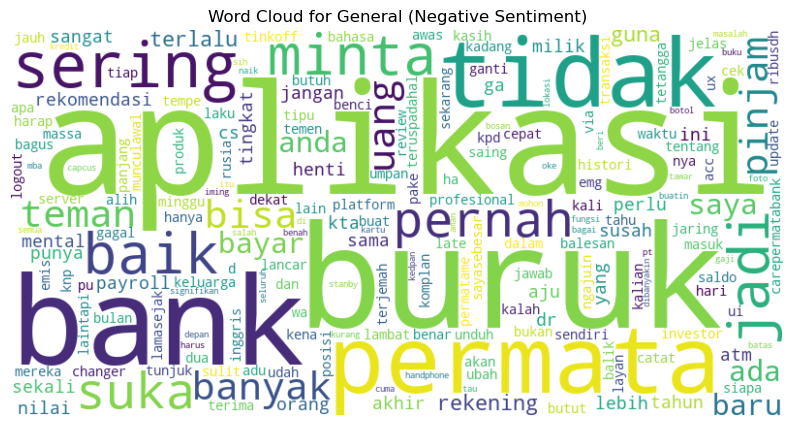

In [17]:
# Generate word clouds for General and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_general)

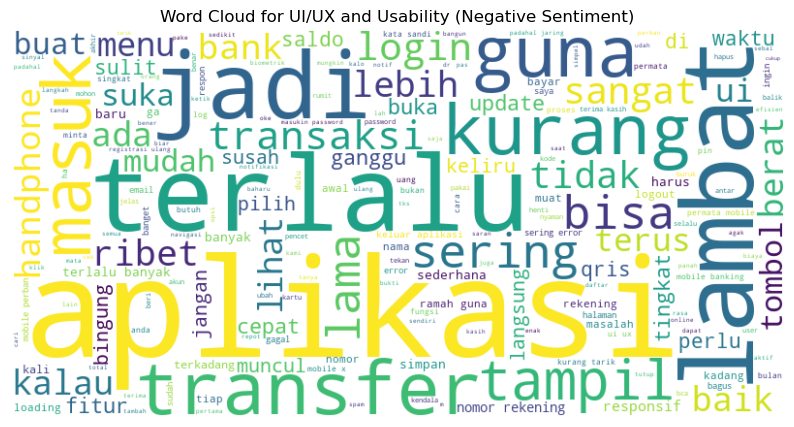

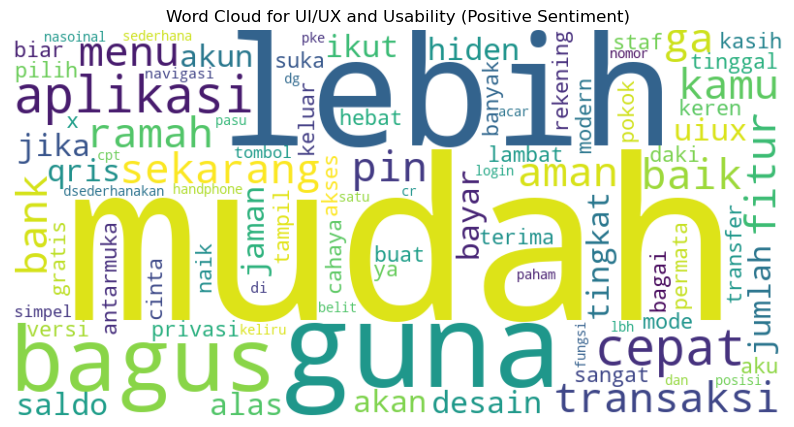

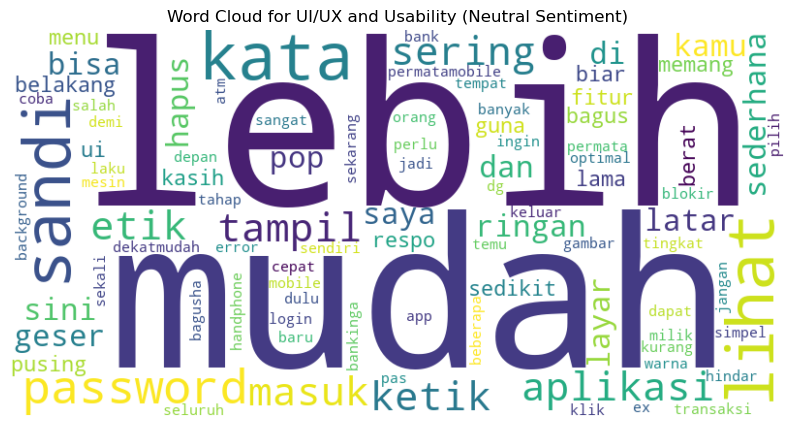

In [18]:
# Generate word clouds for UI/UX and Usability and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_uiux)

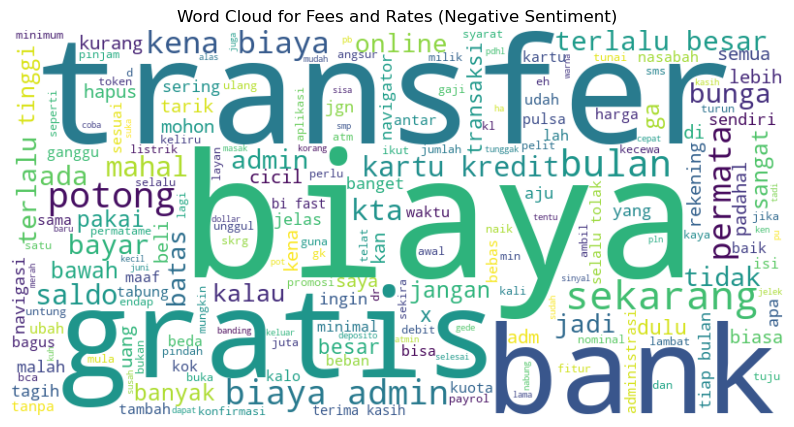

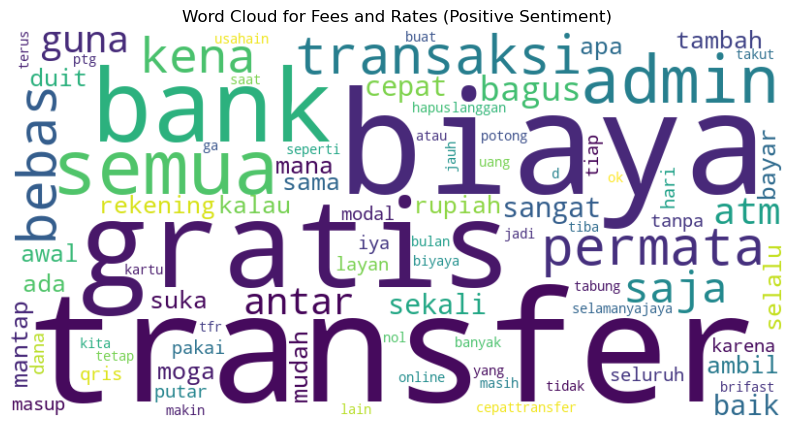

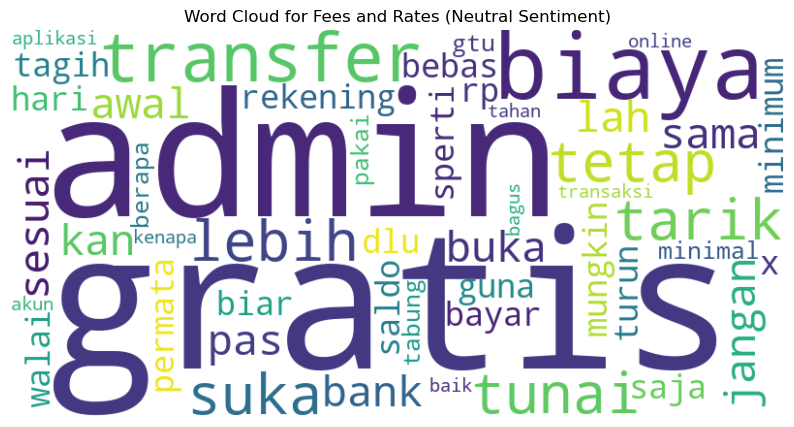

In [19]:
# Generate word clouds for Fees and Rates and Sentiment
generate_wordclouds_by_theme_and_sentiment(df_fees)

### 5. Prepare Data Training

### 6. Training Data

In [20]:
df_stem

Date                                           Feedback Sentiment  \
0     2024-07-14                        ada fitur qris kartu kredit  Negative   
1     2024-07-14                                transfer gagal mulu  Negative   
2     2024-07-14  kalau ubah biometrik registrasi ulang mobile b...  Negative   
3     2024-07-14               bentuk aplikasi kurang tarik praktis  Negative   
4     2024-07-15  transfer bawah hapus padahal keliru satu unggu...  Negative   
...          ...                                                ...       ...   
2434  2024-08-27  aplikasi pertama sedikit berat loginmohon diup...  Negative   
2435  2024-08-27  bayar lalu kode qris sering gagal padahal jari...  Negative   
2436  2024-08-27  butuh akses lebih mudah agen telepon bahasa in...  Negative   
2437  2024-08-27                           masa bisa transfer error  Negative   
2438  2024-08-27                      aplikasi terkadang susah buka  Negative   

                   Key Theme  
0     Features and Promotion  
1                Reliability  
2        UI/UX and Usability  
3        UI/UX and Usability  
4             Fees and Rates  
...                      ...  
2434     UI/UX and Usability  
2435     UI/UX and Usability  
2436                Services  
2437                Services  
2438     UI/UX and Usability  

[2439 rows x 4 columns]

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split data into train and test sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Vectorize text data with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)

# Define classifiers and hyperparameters
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store results
resultsTV = []

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Evaluate for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]  # Convert category name to numeric label
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        resultsTV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsTV = pd.DataFrame(resultsTV)

# Display overall results
df_resultsTV


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Category           Classifier  Accuracy    Recall  \
0           Ease and Speed  Logistic Regression  0.930328  0.777778   
1   Features and Promotion  Logistic Regression  0.842213  0.650000   
2           Fees and Rates  Logistic Regression  0.969262  0.829268   
3                  General  Logistic Regression  0.909836  0.510638   
4              Reliability  Logistic Regression  0.875000  0.517241   
5                 Services  Logistic Regression  0.877049  0.694915   
6      UI/UX and Usability  Logistic Regression  0.899590  0.523810   
7           Ease and Speed        Random Forest  0.899590  0.827160   
8   Features and Promotion        Random Forest  0.829918  0.537500   
9           Fees and Rates        Random Forest  0.965164  0.804878   
10                 General        Random Forest  0.903689  0.595745   
11             Reliability        Random Forest  0.868852  0.448276   
12                Services        Random Forest  0.879098  0.661017   
13     UI/UX and Usability        Random Forest  0.866803  0.333333   
14          Ease and Speed              XGBoost  0.915984  0.765432   
15  Features and Promotion              XGBoost  0.854508  0.650000   
16          Fees and Rates              XGBoost  0.969262  0.853659   
17                 General              XGBoost  0.920082  0.574468   
18             Reliability              XGBoost  0.879098  0.500000   
19                Services              XGBoost  0.862705  0.677966   
20     UI/UX and Usability              XGBoost  0.872951  0.412698   

    Precision  F1 Score  
0    0.797468  0.787500  
1    0.514851  0.574586  
2    0.809524  0.819277  
3    0.533333  0.521739  
4    0.476190  0.495868  
5    0.773585  0.732143  
6    0.634615  0.573913  
7    0.656863  0.732240  
8    0.483146  0.508876  
9    0.785714  0.795181  
10   0.500000  0.543689  
11   0.448276  0.448276  
12   0.804124  0.725581  
13   0.477273  0.392523  
14   0.738095  0.751515  
15   0.547368  0.594286  
16   0.795455  0.823529  
17   0.586957  0.580645  
18   0.491525  0.495726  
19   0.733945  0.704846  
20   0.509804  0.456140

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split data into train and test sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Vectorize text data with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define classifiers and hyperparameters
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store results
resultsTVS = []

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_vectorized, y_train)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Evaluate for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]  # Convert category name to numeric label
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        resultsTVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsTVS = pd.DataFrame(resultsTVS)

# Display overall results
df_resultsTVS


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Category           Classifier  Accuracy    Recall  \
0           Ease and Speed  Logistic Regression  0.932377  0.790123   
1   Features and Promotion  Logistic Regression  0.844262  0.625000   
2           Fees and Rates  Logistic Regression  0.965164  0.829268   
3                  General  Logistic Regression  0.915984  0.574468   
4              Reliability  Logistic Regression  0.872951  0.551724   
5                 Services  Logistic Regression  0.885246  0.669492   
6      UI/UX and Usability  Logistic Regression  0.883197  0.492063   
7           Ease and Speed        Random Forest  0.893443  0.839506   
8   Features and Promotion        Random Forest  0.850410  0.600000   
9           Fees and Rates        Random Forest  0.956967  0.780488   
10                 General        Random Forest  0.918033  0.531915   
11             Reliability        Random Forest  0.872951  0.448276   
12                Services        Random Forest  0.852459  0.677966   
13     UI/UX and Usability        Random Forest  0.868852  0.269841   
14          Ease and Speed              XGBoost  0.905738  0.740741   
15  Features and Promotion              XGBoost  0.829918  0.575000   
16          Fees and Rates              XGBoost  0.963115  0.804878   
17                 General              XGBoost  0.922131  0.553191   
18             Reliability              XGBoost  0.868852  0.448276   
19                Services              XGBoost  0.872951  0.728814   
20     UI/UX and Usability              XGBoost  0.854508  0.317460   

    Precision  F1 Score  
0    0.800000  0.795031  
1    0.520833  0.568182  
2    0.772727  0.800000  
3    0.562500  0.568421  
4    0.470588  0.507937  
5    0.822917  0.738318  
6    0.553571  0.521008  
7    0.635514  0.723404  
8    0.539326  0.568047  
9    0.727273  0.752941  
10   0.581395  0.555556  
11   0.464286  0.456140  
12   0.701754  0.689655  
13   0.485714  0.346939  
14   0.705882  0.722892  
15   0.484211  0.525714  
16   0.767442  0.785714  
17   0.604651  0.577778  
18   0.448276  0.448276  
19   0.741379  0.735043  
20   0.416667  0.360360

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split data into train and test sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Vectorize text data with CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectorized, y_train)

# Define classifiers and hyperparameters
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store results
resultsCV = []

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_smote, y_train_smote)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Evaluate for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]  # Convert category name to numeric label
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        resultsCV.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsCV = pd.DataFrame(resultsCV)

# Display overall results
df_resultsCV


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Category           Classifier  Accuracy    Recall  \
0           Ease and Speed  Logistic Regression  0.920082  0.740741   
1   Features and Promotion  Logistic Regression  0.829918  0.562500   
2           Fees and Rates  Logistic Regression  0.961066  0.780488   
3                  General  Logistic Regression  0.911885  0.553191   
4              Reliability  Logistic Regression  0.866803  0.482759   
5                 Services  Logistic Regression  0.879098  0.661017   
6      UI/UX and Usability  Logistic Regression  0.864754  0.507937   
7           Ease and Speed        Random Forest  0.905738  0.740741   
8   Features and Promotion        Random Forest  0.821721  0.425000   
9           Fees and Rates        Random Forest  0.950820  0.902439   
10                 General        Random Forest  0.903689  0.595745   
11             Reliability        Random Forest  0.831967  0.431034   
12                Services        Random Forest  0.875000  0.567797   
13     UI/UX and Usability        Random Forest  0.850410  0.428571   
14          Ease and Speed              XGBoost  0.924180  0.790123   
15  Features and Promotion              XGBoost  0.823770  0.625000   
16          Fees and Rates              XGBoost  0.963115  0.731707   
17                 General              XGBoost  0.909836  0.553191   
18             Reliability              XGBoost  0.883197  0.500000   
19                Services              XGBoost  0.858607  0.669492   
20     UI/UX and Usability              XGBoost  0.875000  0.380952   

    Precision  F1 Score  
0    0.769231  0.754717  
1    0.483871  0.520231  
2    0.761905  0.771084  
3    0.541667  0.547368  
4    0.444444  0.462810  
5    0.804124  0.725581  
6    0.477612  0.492308  
7    0.705882  0.722892  
8    0.453333  0.438710  
9    0.649123  0.755102  
10   0.500000  0.543689  
11   0.337838  0.378788  
12   0.870130  0.687179  
13   0.421875  0.425197  
14   0.761905  0.775758  
15   0.471698  0.537634  
16   0.810811  0.769231  
17   0.530612  0.541667  
18   0.508772  0.504348  
19   0.724771  0.696035  
20   0.521739  0.440367

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split data into train and test sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Vectorize text data with CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define classifiers and hyperparameters
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store results
resultsCVS = []

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_vectorized, y_train)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Evaluate for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]  # Convert category name to numeric label
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        resultsCVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsCVS = pd.DataFrame(resultsCVS)

# Display overall results
df_resultsCVS


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Category           Classifier  Accuracy    Recall  \
0           Ease and Speed  Logistic Regression  0.915984  0.740741   
1   Features and Promotion  Logistic Regression  0.827869  0.612500   
2           Fees and Rates  Logistic Regression  0.971311  0.829268   
3                  General  Logistic Regression  0.903689  0.595745   
4              Reliability  Logistic Regression  0.870902  0.517241   
5                 Services  Logistic Regression  0.883197  0.652542   
6      UI/UX and Usability  Logistic Regression  0.868852  0.396825   
7           Ease and Speed        Random Forest  0.893443  0.827160   
8   Features and Promotion        Random Forest  0.819672  0.487500   
9           Fees and Rates        Random Forest  0.961066  0.731707   
10                 General        Random Forest  0.901639  0.617021   
11             Reliability        Random Forest  0.864754  0.396552   
12                Services        Random Forest  0.862705  0.686441   
13     UI/UX and Usability        Random Forest  0.885246  0.333333   
14          Ease and Speed              XGBoost  0.920082  0.777778   
15  Features and Promotion              XGBoost  0.813525  0.650000   
16          Fees and Rates              XGBoost  0.969262  0.804878   
17                 General              XGBoost  0.913934  0.553191   
18             Reliability              XGBoost  0.879098  0.465517   
19                Services              XGBoost  0.870902  0.686441   
20     UI/UX and Usability              XGBoost  0.883197  0.365079   

    Precision  F1 Score  
0    0.750000  0.745342  
1    0.480392  0.538462  
2    0.829268  0.829268  
3    0.500000  0.543689  
4    0.461538  0.487805  
5    0.827957  0.729858  
6    0.490196  0.438596  
7    0.638095  0.720430  
8    0.453488  0.469880  
9    0.789474  0.759494  
10   0.491525  0.547170  
11   0.425926  0.410714  
12   0.729730  0.707424  
13   0.600000  0.428571  
14   0.750000  0.763636  
15   0.452174  0.533333  
16   0.825000  0.814815  
17   0.553191  0.553191  
18   0.490909  0.477876  
19   0.757009  0.720000  
20   0.575000  0.446602

In [25]:
# import os
# import pandas as pd

# # Ensure the 'Data' folder exists
# os.makedirs('Data', exist_ok=True)

# # Define the file path
# file_path = 'Data/results2.xlsx'

# # Save to an Excel file
# with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
#     df_resultsTV.to_excel(writer, index=False, sheet_name='TV with SMOTE')
#     df_resultsTVS.to_excel(writer, index=False, sheet_name='TV without SMOTE')
#     df_resultsCV.to_excel(writer, index=False, sheet_name='CV with SMOTE')
#     df_resultsCVS.to_excel(writer, index=False, sheet_name='CV without SMOTE')

# print(f"Excel file saved to {file_path}")


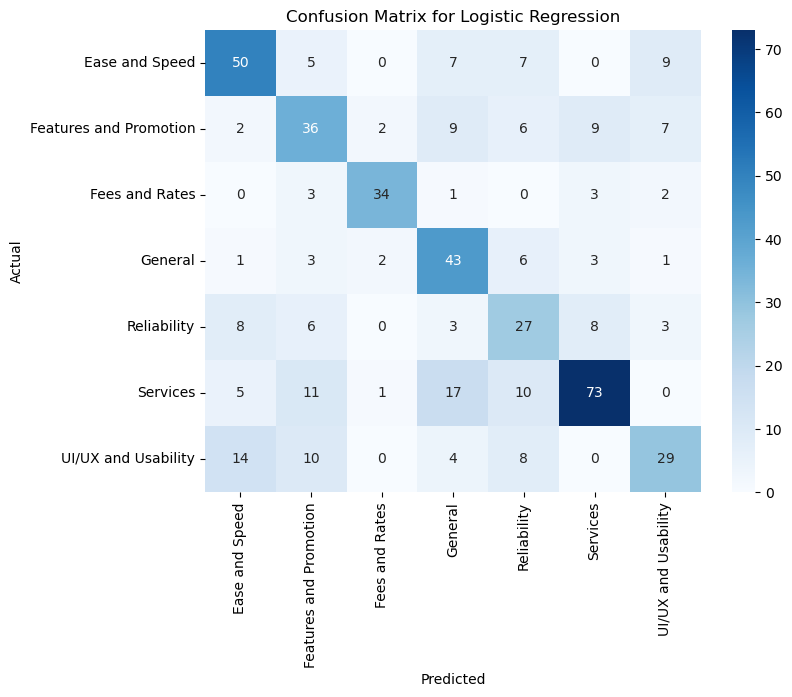

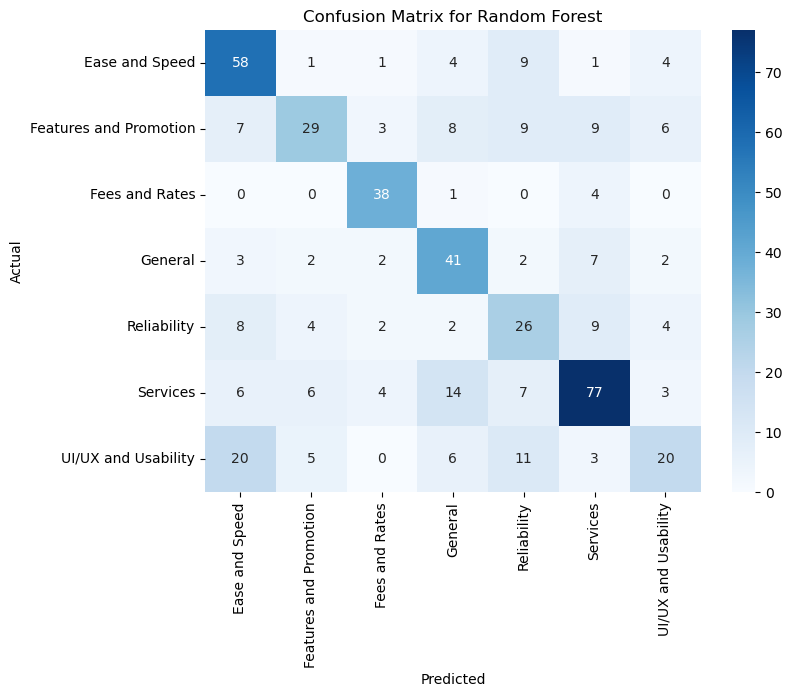

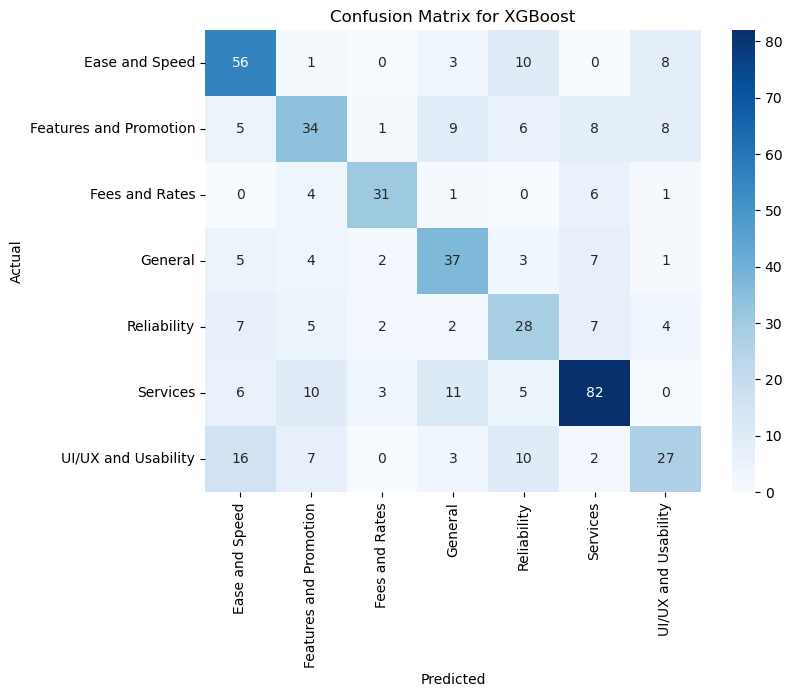

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Vectorize data using CountVectorizer
vectorizer = CountVectorizer()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Loop over each classifier and generate confusion matrix
for clf_name, clf in classifiers.items():
    # Vectorize training and test data
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()

    # Train the classifier
    clf.fit(X_train_vectorized, y_train)

    # Predict on the test data
    y_pred = clf.predict(X_test_vectorized)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

    # Add titles and labels
    plt.title(f"Confusion Matrix for {clf_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


### 7. Testing with best combined technique and algorithm: TFIDF without SMOTE and Logistic Regression

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_stem['Key Theme'])

# Split data into train and test sets
X = df_stem['Feedback']
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split data into train and test sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Vectorize text data with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define classifiers and hyperparameters
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Store results
resultsTVS = []

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    
    # Train the classifier
    clf.fit(X_train_vectorized, y_train)
    
    # Predict on test data
    y_pred = clf.predict(X_test_vectorized)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Evaluate for each category
    for category in label_encoder.classes_:
        category_idx = label_encoder.transform([category])[0]  # Convert category name to numeric label
        y_test_category = (y_test == category_idx).astype(int)
        y_pred_category = (y_pred == category_idx).astype(int)
        category_accuracy = accuracy_score(y_test_category, y_pred_category)
        category_recall = recall_score(y_test_category, y_pred_category)
        category_precision = precision_score(y_test_category, y_pred_category)
        category_f1 = f1_score(y_test_category, y_pred_category)
        
        resultsTVS.append({
            'Category': category,
            'Classifier': clf_name,
            'Accuracy': category_accuracy,
            'Recall': category_recall,
            'Precision': category_precision,
            'F1 Score': category_f1
        })

# Convert results to DataFrame for easy display
df_resultsTVS = pd.DataFrame(resultsTVS)

# Display overall results
df_resultsTVS


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


Category           Classifier  Accuracy    Recall  \
0           Ease and Speed  Logistic Regression  0.932377  0.790123   
1   Features and Promotion  Logistic Regression  0.844262  0.625000   
2           Fees and Rates  Logistic Regression  0.965164  0.829268   
3                  General  Logistic Regression  0.915984  0.574468   
4              Reliability  Logistic Regression  0.872951  0.551724   
5                 Services  Logistic Regression  0.885246  0.669492   
6      UI/UX and Usability  Logistic Regression  0.883197  0.492063   
7           Ease and Speed        Random Forest  0.893443  0.839506   
8   Features and Promotion        Random Forest  0.850410  0.600000   
9           Fees and Rates        Random Forest  0.956967  0.780488   
10                 General        Random Forest  0.918033  0.531915   
11             Reliability        Random Forest  0.872951  0.448276   
12                Services        Random Forest  0.852459  0.677966   
13     UI/UX and Usability        Random Forest  0.868852  0.269841   
14          Ease and Speed              XGBoost  0.905738  0.740741   
15  Features and Promotion              XGBoost  0.829918  0.575000   
16          Fees and Rates              XGBoost  0.963115  0.804878   
17                 General              XGBoost  0.922131  0.553191   
18             Reliability              XGBoost  0.868852  0.448276   
19                Services              XGBoost  0.872951  0.728814   
20     UI/UX and Usability              XGBoost  0.854508  0.317460   

    Precision  F1 Score  
0    0.800000  0.795031  
1    0.520833  0.568182  
2    0.772727  0.800000  
3    0.562500  0.568421  
4    0.470588  0.507937  
5    0.822917  0.738318  
6    0.553571  0.521008  
7    0.635514  0.723404  
8    0.539326  0.568047  
9    0.727273  0.752941  
10   0.581395  0.555556  
11   0.464286  0.456140  
12   0.701754  0.689655  
13   0.485714  0.346939  
14   0.705882  0.722892  
15   0.484211  0.525714  
16   0.767442  0.785714  
17   0.604651  0.577778  
18   0.448276  0.448276  
19   0.741379  0.735043  
20   0.416667  0.360360

In [30]:
import joblib

# Save trained components
joblib.dump(vectorizer, "vectorizer_tfidf.pkl")
joblib.dump(classifiers['Logistic Regression'], "logistic_regression_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Trained models and vectorizer have been saved.")

Trained models and vectorizer have been saved.


In [27]:
import numpy as np

# Fungsi untuk melakukan prediksi pada data baru
def predict_new_feedback(feedback, vectorizer, classifiers, label_encoder):
    """
    Predict category for a given feedback using trained classifiers.

    Parameters:
    - feedback (str): New feedback to classify.
    - vectorizer: Trained CountVectorizer instance.
    - classifiers (dict): Dictionary of trained classifiers.
    - label_encoder: Trained LabelEncoder instance.

    Returns:
    - predictions (dict): Predicted category for each classifier.
    """
    # Preprocess and vectorize the input feedback
    feedback_vectorized = vectorizer.transform([feedback])

    predictions = {}
    for clf_name, clf in classifiers.items():
        # Predict the encoded label
        encoded_label = clf.predict(feedback_vectorized)
        
        # Decode the label back to the original category name
        predicted_category = label_encoder.inverse_transform(encoded_label)[0]
        predictions[clf_name] = predicted_category

    return predictions

# Contoh data baru untuk diprediksi
new_feedback = "PEMBUATAN KODE QRIS SANGAT SUSAH, SAMPAI SALES NYA DATANG PUN SUSAH"

# Lakukan prediksi
predictions = predict_new_feedback(new_feedback, vectorizer, classifiers, label_encoder)

# Tampilkan hasil prediksi
print("Prediksi kategori untuk feedback baru:")
for clf_name, category in predictions.items():
    print(f"{clf_name}: {category}")


Prediksi kategori untuk feedback baru:
Logistic Regression: Features and Promotion
Random Forest: Features and Promotion
XGBoost: Features and Promotion


In [31]:
import pandas as pd
from openpyxl import Workbook
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import joblib

# Function to predict categories for feedbacks in an Excel file
def predict_feedback_from_excel(input_excel, output_excel, vectorizer, classifier, label_encoder):
    """
    Predict categories for feedbacks in an Excel file and save the results.

    Parameters:
    - input_excel (str): Path to the input Excel file with feedback data.
    - output_excel (str): Path to save the output Excel file with predictions.
    - vectorizer: Trained TfidfVectorizer instance.
    - classifier: Trained Logistic Regression classifier.
    - label_encoder: Trained LabelEncoder instance.
    """
    # Load the input Excel file
    df = pd.read_excel(input_excel)

    # Ensure the column containing feedback is named "Feedback"
    if 'Feedback' not in df.columns:
        raise ValueError("Input Excel file must have a 'Feedback' column.")

    # Preprocess and vectorize the feedback
    feedback_vectorized = vectorizer.transform(df['Feedback'])

    # Predict categories
    encoded_labels = classifier.predict(feedback_vectorized)
    decoded_labels = label_encoder.inverse_transform(encoded_labels)
    df["Prediction"] = decoded_labels

    # Save the results to a new Excel file
    df.to_excel(output_excel, index=False)
    print(f"Hasil prediksi telah disimpan ke: {output_excel}")

# Load trained models
vectorizer = joblib.load("vectorizer_tfidf.pkl")
classifier = joblib.load("logistic_regression_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Example usage
input_excel_path = "Data/datafeedbacknew.xlsx"  # Path ke file Excel masukan
output_excel_path = "Data/datafeedbackcategorizedlogistic.xlsx"  # Path ke file Excel keluaran

predict_feedback_from_excel(
    input_excel=input_excel_path,
    output_excel=output_excel_path,
    vectorizer=vectorizer,
    classifier=classifier,
    label_encoder=label_encoder
)

Hasil prediksi telah disimpan ke: Data/datafeedbackcategorizedlogistic.xlsx
